###### Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from src.NN_sans_bias import ConstrainedMLPClassifier
from src.utils import nudge_dataset, plot_sample, inversion_symmetric_features

###### Initial data preparation

In [3]:
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling
X = 2*X - 1 # [-1,1] scaling

###### Training on the original dataset

In [4]:
hidden_layer_sizes = (10, 5)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

model1 = MLPClassifier(solver='lbfgs',
                        alpha=1e-5,
                        activation='tanh',
                        hidden_layer_sizes=hidden_layer_sizes,
                        random_state=1)

model2 = ConstrainedMLPClassifier(solver='lbfgs',
                                  alpha=1e-5, activation='tanh',
                                  hidden_layer_sizes=hidden_layer_sizes,
                                  random_state=2,
                                  fit_intercepts=False)

model1.fit(X_train, Y_train)
model2.fit(X_train, Y_train)

ConstrainedMLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto',
             beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
             fit_intercepts=False, hidden_layer_sizes=(10, 5),
             learning_rate='constant', learning_rate_init=0.001,
             max_iter=200, momentum=0.9, nesterovs_momentum=True,
             power_t=0.5, random_state=2, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [6]:
def accuracy(y_true, y_pred):
    return (y_true==y_pred).sum()/len(y_true)

In [7]:
result_1 = "NN model with biases test results:\n{}\n".format(
    metrics.classification_report(
        Y_test,
        model1.predict(X_test)))
print(result_1)

result_2 = "NN model without biases test results:\n{}\n".format(
    metrics.classification_report(
        Y_test,
        model2.predict(X_test)))
print(result_2)

print("And now on the inverted set:")

result_3 = "NN model with biases test results on inverted test set:\n{}\n".format(
    metrics.classification_report(
        Y_test,
        model1.predict(-X_test)))
print(result_3)

result_4 = "NN model without biases on inverted test results:\n{}\n".format(
    metrics.classification_report(
        Y_test,
        model2.predict(-X_test)))
print(result_4)

NN model with biases test results:
             precision    recall  f1-score   support

          0       0.88      0.91      0.89       174
          1       0.79      0.70      0.74       184
          2       0.80      0.87      0.83       166
          3       0.82      0.81      0.82       194
          4       0.88      0.87      0.87       186
          5       0.86      0.78      0.82       181
          6       0.90      0.90      0.90       207
          7       0.86      0.84      0.85       154
          8       0.70      0.69      0.69       182
          9       0.64      0.72      0.68       169

avg / total       0.81      0.81      0.81      1797


NN model without biases test results:
             precision    recall  f1-score   support

          0       0.94      0.94      0.94       174
          1       0.78      0.77      0.77       184
          2       0.83      0.92      0.87       166
          3       0.84      0.81      0.83       194
          4       0.8

/home/doron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
print(f"{accuracy(Y_test, model1.predict(X_test)):.3f}")
print(f"{accuracy(Y_test, model2.predict(X_test)):.3f}")
print(f"{accuracy(Y_test, model1.predict(-X_test)):.3f}")
print(f"{accuracy(Y_test, model2.predict(-X_test)):.3f}")

0.811
0.839
0.021
0.001


###### training on both the original data and the inverted data

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

model1b = MLPClassifier(solver='lbfgs',
                        alpha=1e-5,
                        activation='tanh',
                        hidden_layer_sizes=hidden_layer_sizes,
                        random_state=1)

model2b = ConstrainedMLPClassifier(solver='lbfgs',
                                  alpha=1e-5, activation='tanh',
                                  hidden_layer_sizes=hidden_layer_sizes,
                                  random_state=2,
                                  fit_intercepts=False)

X_train_2 = np.vstack((X_train, -X_train))
Y_train_2 = np.hstack((Y_train,  Y_train))

assert X_train_2.shape[1]==64

model1b.fit(X_train_2, Y_train_2)
model2b.fit(X_train_2, Y_train_2)

ConstrainedMLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto',
             beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
             fit_intercepts=False, hidden_layer_sizes=(10, 5),
             learning_rate='constant', learning_rate_init=0.001,
             max_iter=200, momentum=0.9, nesterovs_momentum=True,
             power_t=0.5, random_state=2, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [10]:
result_5 = "NN model with biases trained on original+inverted dataset test results:\n{}\n".format(
    metrics.classification_report(
        Y_test,
        model1b.predict(X_test)))
print(result_5)

result_6 = "NN model without biases trained on original+inverted dataset test results:\n{}\n".format(
    metrics.classification_report(
        Y_test,
        model2b.predict(X_test)))
print(result_6)

print("And now on the inverted set:")


print("un-constrained NN model test results:\n{}\n".format(
    metrics.classification_report(
        Y_test,
        model1b.predict(-X_test))))

print("constrained NN model test results:\n{}\n".format(
    metrics.classification_report(
        Y_test,
        model2b.predict(-X_test))))

NN model with biases trained on original+inverted dataset test results:
             precision    recall  f1-score   support

          0       0.80      0.94      0.86       174
          1       0.55      0.52      0.53       184
          2       0.59      0.67      0.63       166
          3       0.66      0.63      0.65       194
          4       0.93      0.86      0.89       186
          5       0.31      0.15      0.20       181
          6       0.80      0.95      0.87       207
          7       0.79      0.88      0.83       154
          8       0.52      0.55      0.53       182
          9       0.62      0.64      0.63       169

avg / total       0.66      0.68      0.66      1797


NN model without biases trained on original+inverted dataset test results:
             precision    recall  f1-score   support

          0       0.02      0.01      0.01       174
          1       0.13      0.23      0.17       184
          2       0.04      0.03      0.03       166


/home/doron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
print(f"{accuracy(Y_test, model1b.predict(X_test)):.3f}")
print(f"{accuracy(Y_test, model2b.predict(X_test)):.3f}")
print(f"{accuracy(Y_test, model1b.predict(-X_test)):.3f}")
print(f"{accuracy(Y_test, model2b.predict(-X_test)):.3f}")

0.679
0.119
0.691
0.091


###### train on symmetric features

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

model3 = ConstrainedMLPClassifier(solver='lbfgs',
                                  alpha=1e-5, activation='tanh',
                                  hidden_layer_sizes=hidden_layer_sizes,
                                  random_state=1,
                                  fit_intercepts=False)

XX_train = inversion_symmetric_features(X_train)
XX_test = inversion_symmetric_features(X_test)

np.testing.assert_allclose(XX_test, inversion_symmetric_features(-X_test))

model3.fit(XX_train, Y_train)

ConstrainedMLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto',
             beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
             fit_intercepts=False, hidden_layer_sizes=(10, 5),
             learning_rate='constant', learning_rate_init=0.001,
             max_iter=200, momentum=0.9, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [13]:
result_string = "constrained NN model test results:\n{}\n".format(
    metrics.classification_report(
        Y_test,
        model3.predict(XX_test)))

print(result_string)

constrained NN model test results:
             precision    recall  f1-score   support

          0       0.89      0.91      0.90       174
          1       0.85      0.85      0.85       184
          2       0.78      0.90      0.84       166
          3       0.79      0.77      0.78       194
          4       0.85      0.85      0.85       186
          5       0.89      0.82      0.85       181
          6       0.94      0.93      0.93       207
          7       0.81      0.95      0.88       154
          8       0.81      0.72      0.76       182
          9       0.77      0.69      0.73       169

avg / total       0.84      0.84      0.84      1797




In [14]:
print(f"{accuracy(Y_test, model3.predict(XX_test)):.3f}")

0.840


now plot the features for y=6


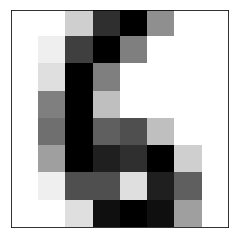

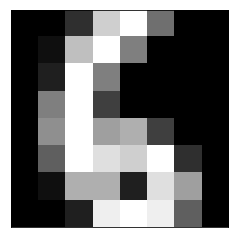

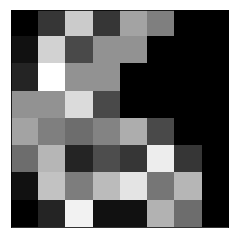

In [15]:
import matplotlib.pyplot as plt

# idx = 0
# print(f"now plot the features for y={digits.target[idx]}")
# x = digits.data[idx, :]
# plot_sample(x)
# print(x.shape)
#
# _x = x.reshape(1, 64)
# _xx = -1 + 2*(_x - np.min(_x)) / (np.max(_x) - np.min(_x) + 0.0001)  # [-1,1] scaling
#
# xx = inversion_symmetric_features(_xx)
# plot_sample(xx)


idx = 1173

x = -1 + 2*digits.data[idx]/16
y = digits.target[idx]
xx = inversion_symmetric_features(np.array([x]))

print(f"now plot the features for y={y}")
plot_sample(x)
# plt.savefig(f"./original_features_digit_{y}.png")
# plt.show()

plot_sample(-x)
# plt.savefig(f"./inverted_features_digit_{y}.png")
# plt.show()

plot_sample(xx[0,:])
# plt.savefig(f"./gradient_features_digit_{y}.png")
# plt.show()



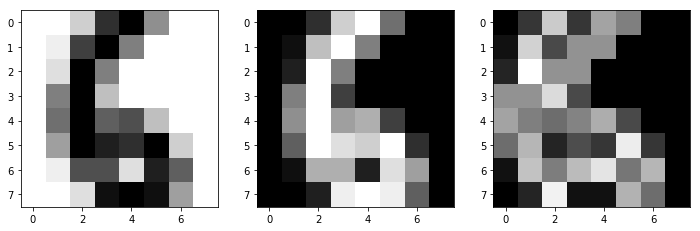

In [16]:
fig, axes = plt.subplots(1,3, figsize=(12, 4))

axes[0].imshow(x.reshape((8,8)), cmap=plt.cm.gray_r,
           interpolation='nearest')

axes[1].imshow(-x.reshape((8,8)), cmap=plt.cm.gray_r,
           interpolation='nearest')

axes[2].imshow(xx[0,:].reshape((8,8)), cmap=plt.cm.gray_r,
           interpolation='nearest');

# plt.savefig("./notes/images/six_cubed.png")